In [1]:
import pandas as pd
from google.colab import files
uploaded=files.upload()

Saving FDF.xlsx to FDF.xlsx


In [2]:
import io
data=pd.read_excel(io.BytesIO(uploaded['FDF.xlsx']))
data

,username,name,tweet,hashtags,Jobs,embed,bio,main_Job,CLUSTERS,emojie,tweet_comb,pre_pro,No_emo,bio_new,hashtags_subs,pre_pro_RHRW,pre_pro_RH,pre_pro_RHW
0,GiGiHadid,Gigi Hadid,"['few things 😋🙃😘', 'You were facing the right ...",giforce,model,['model'],IMG Models Worldwide. #giforce,model,2,sparkles,"IMG Models Worldwide. #giforce ['few things ',...",img models worldwide thing face right way exac...,IMG Models Worldwide. #giforce,img models worldwide,giforce,img models worldwide thing face right way exac...,img models worldwide thing face right way exac...,img models worldwide thing face right way exac...
1,Cantguardmike,Michael William Thomas Jr.,"['Facts !', '@jhardee_19 called it like 2 mont...",gobucks,football wide receiver,['receiver'],GOD GOT US,footballer,3,NaN,"GOD GOT US ['Facts !', '@jhardee_19 called it ...",fact call like month ago congratulation get re...,GOD GOT US,NaN,gobucks,fact call like month ago congratulation get re...,fact call like month ago congratulation get re...,fact call like month ago congratulation get re...
2,IAMJHUD,Jennifer Hudson,"['Team JHud, please help me wish my Virgo sist...","neverforget,baobabstudios,respectmovie,ebony,v...","singer , actress","['singer', 'actress']","Grammy winning Artist, Academy Award winning A...",singer actress,4,sparkles,"Grammy winning Artist, Academy Award winning A...",grammy win artist academy award win actress ne...,"Grammy winning Artist, Academy Award winning A...",grammy win artist academy award win actress ne...,business twitter,grammy win artist academy award win actress ne...,grammy win artist academy award win actress ne...,grammy win artist academy award win actress ne...
3,lukajones,Luka Jones,"['@johnnypemberton Here we go 🏈', 'gracias for...","goclippers,rcjh,topcity,goblue,rcjh","actor , comedian","['actor', 'comedian']",actor (Shrill & People of Earth both on @hulu)...,actor comedian,6,baseball football basketball,actor (Shrill & People of Earth both on @hulu)...,actor thrill people earth philosophy reader ch...,actor (Shrill & People of Earth both on @hulu)...,actor thrill people earth philosophy reader ch...,thrill people,actor thrill people earth philosophy reader ch...,actor thrill people earth philosophy reader ch...,actor thrill people earth philosophy reader ch...
4,rcobb18,Randall Cobb (American football),['Man It Feels Good to Be a Packer https://t....,"mvp,ad,winitforted,jerseyswap,verzuz,ad,jersey...",football wide receiver,['receiver'],Faith in the Creator of Life. Husband. Father....,footballer,3,football,Faith in the Creator of Life. Husband. Father....,faith creator life husband father son brother ...,Faith in the Creator of Life. Husband. Father....,faith creator life husband father son brother ...,creator faith,faith creator life husband father son brother ...,faith creator life husband father son brother ...,faith creator life husband father son brother ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,ColinHanks,Colin Hanks,['@PFTompkins The old man has a pretty sweet c...,"hankskerchiefs,hankskerchiefs,beready,beready,tbt","actor , producer , director","['actor', 'producer']",NaN,actor producer,6,NaN,['@PFTompkins The old man has a pretty sweet ...,old man pretty sweet chariot right well play m...,NaN,NaN,official com,old man pretty sweet chariot right well play m...,old man pretty sweet chariot right well play m...,old man pretty sweet chariot right well play m...
1310,CraigyFerg,Craig Ferguson,['Tonight! @TheHustlerABC @ABCNetwork #thecrai...,"thecraigfergusonshow,thecraigfergusonshow,theh...","actor , author , comedian , television host","['actor', 'author']",NaN,actor author,1,NaN,['Tonight! @TheHustlerABC @ABCNetwork #thecra...,tonight thursday june season premiere miss sus...,NaN,NaN,instagram thehustler,tonight thursday june season premiere miss sus...,tonight thursday june season premiere miss sus...,tonight thursday june season premiere miss sus...
1311,GeraldFinley,Gerald Finley,['

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
train_samples, val_samples, train_labels, val_labels = train_test_split(data.pre_pro_RHRW,data.CLUSTERS.to_list(), 
                                                                                        test_size=0.2, random_state=40)

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-09-23 21:01:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-23 21:01:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-23 21:01:59--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
!unzip -q glove.6B.zip

In [44]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [45]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [46]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [47]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 16183 words (3614 misses)


In [48]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [60]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 4, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 4, activation="relu")(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(128, 4, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(9, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 100)         1979900   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, None, 128)         51328     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, None, 128)         65664     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, None, 128)         6566

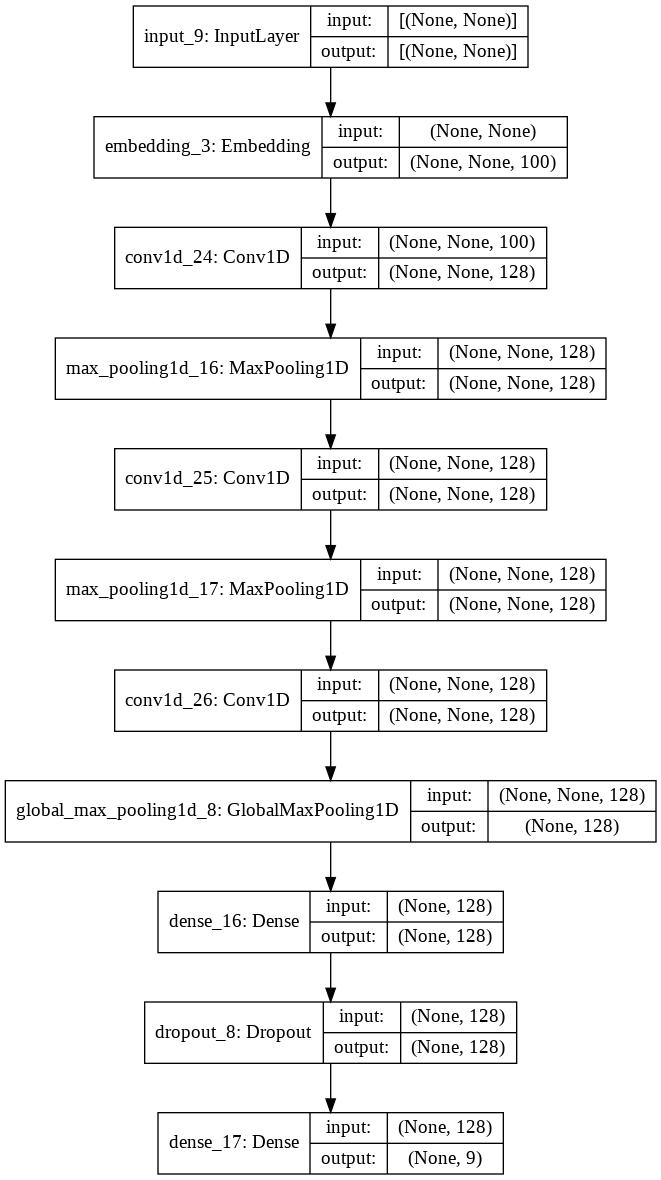

In [61]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_CNN.png', show_shapes=True, show_layer_names=True)

In [62]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [64]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=64, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
17/17 [==============================] - 3s 135ms/step - loss: 1.4864 - acc: 0.5880 - val_loss: 1.9482 - val_acc: 0.2586
Epoch 2/15
17/17 [==============================] - 2s 113ms/step - loss: 0.9066 - acc: 0.7383 - val_loss: 1.8398 - val_acc: 0.2662
Epoch 3/15
17/17 [==============================] - 2s 114ms/step - loss: 0.7372 - acc: 0.7793 - val_loss: 2.0930 - val_acc: 0.2395
Epoch 4/15
17/17 [==============================] - 2s 114ms/step - loss: 0.6887 - acc: 0.8040 - val_loss: 2.0343 - val_acc: 0.2586
Epoch 5/15
17/17 [==============================] - 2s 114ms/step - loss: 0.6077 - acc: 0.8411 - val_loss: 2.1981 - val_acc: 0.2814
Epoch 6/15
17/17 [==============================] - 2s 113ms/step - loss: 0.5244 - acc: 0.8696 - val_loss: 1.8447 - val_acc: 0.3384
Epoch 7/15
17/17 [==============================] - 2s 115ms/step - loss: 0.4650 - acc: 0.8972 - val_loss: 2.0388 - val_acc: 0.3460
Epoch 8/15
17/17 [==============================] - 2s 113ms/step - loss: 0.

In [65]:
from sklearn import metrics
predicted = np.argmax(model.predict(x_val),axis=1)#model_DNN.predict_class(X_test_tfidf)
print(metrics.classification_report(y_val, predicted))

              precision    recall  f1-score   support

           0       0.56      0.51      0.54        43
           1       0.40      0.41      0.41        29
           2       0.35      0.24      0.29        45
           3       0.44      0.63      0.52        19
           4       0.36      0.28      0.31        36
           5       0.44      0.32      0.37        22
           6       0.29      0.51      0.37        37
           7       0.41      0.56      0.47        16
           8       0.00      0.00      0.00        16

    accuracy                           0.39       263
   macro avg       0.36      0.39      0.36       263
weighted avg       0.38      0.39      0.37       263

